# Problem Statement

Consider this dataset Oscars-demographics.csv, which can be downloaded from Blackboard. The given dataset contains records about the race, religion, age, and other demographic details of all Oscar winners from 1927 to 2014 in various categories such as best actor, best actress, best supporting actor, best supporting actress, and best director. 
# Objective: 
Using the given dataset, develop a predictive model to predict which type of award is won by a person based on a range of features such as country of origin, race, age, etc. and to propose a set of clusters that may make business sense of the movies industry.

# Exploring the data

Your first task is to prepare the data and carry out data munging or cleansing, bearing in mind the question you would like to answer. Namely, what is the impact of country of origin, race, religion, age in winning an Oscar award? Address the following questions:

# 1 Part 1 - Building up a basic predictive model

Load the dataset, and consider the subset of the dataframe formed by the following columns:

cols = [’birthplace’, ’date_of_birth’,’race_ethnicity’, ’year_of_award’, ’award’] In this section, we will only analyse this subset of the given dataset.

1. Data cleaning: Using pandas, show the first 3 rows of the subset. Then, display all the distinct values for the column award in the entire subset. If you have a closer look at the entire subset, you will see that there are some inconsistencies on the way the birthdays have been recorded and that for some rows, the country of origin is missing. Add a new column ldob to your current dataframe to record the length of the date of birth for each row; then show the distinct values in the column ldob. Write the following functions:

In [1]:
## Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans  
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importing the dataset
# Reading the provided Dataset        // encoding = ac-roman used as file was created in a mac Format originally.
# Selecting birthplace, date_of_birth, race_ethnicity, year_of_award and award columns
# Printing the first 3 rows of the dataset.
data = pd.read_csv('oscars-demographics.csv', encoding ='mac-roman')

dataset = data[['birthplace','date_of_birth','race_ethnicity','year_of_award','award']]
dataset_2= data[['sexual_orientation','movie','religion','person']]
dataset.head(3)


,birthplace,date_of_birth,race_ethnicity,year_of_award,award
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director


In [49]:
# Displaying all unique values in the column award of the dataset
dataset['award'].unique()

array(['Best Director', 'Best Actor', 'Best Supporting Actor',
       'Best Actress', 'Best Supporting Actress'], dtype=object)

## Web scraping to pull in the gender to be used when improving our models

In [3]:

def extraFeatures(link):
    import requests
    from bs4 import BeautifulSoup
    page = requests.get(link)
    soup = BeautifulSoup(page.content)
    
#using if else statements we search the page for bold text of Gender 
    if soup.findAll("p")[2].findAll("b")[0].text == 'Gender:' :
        para = soup.findAll("p")[2]
        lis = str(para).split("br/>")
    elif soup.findAll("p")[1].findAll("b")[0].text == 'Gender:' :
        para = soup.findAll("p")[1]
        lis = str(para).split("<br/>")
    else:
        lis = []

    return lis

features = data.biourl.apply(lambda url:extraFeatures(url))
extrafeaturedataset = pd.concat((data.biourl, features.rename('Feature')), axis=1)


#putting scrapped data into new csv file 
extrafeaturedataset.to_csv("extraDataset.csv")

## Reading in from our new CSV file

In [4]:
extrafeaturedataset =pd.read_csv("extraDataset.csv")
extrafeaturedataset.head(3)

,Unnamed: 0,biourl,Feature
0,0,http://www.nndb.com/people/320/000043191/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."
1,1,http://www.nndb.com/people/626/000042500/,"['<p><b>Gender:</b> Male', '<b>Race or Ethnici..."
2,2,http://www.nndb.com/people/320/000043191/,"['<p><b>Gender:</b> Male<', '<b>Race or Ethnic..."


In [5]:
import ast

In [6]:
extrafeaturedataset.Feature = extrafeaturedataset.Feature.apply(lambda txt: ast.literal_eval(txt))
extrafeaturedataset['Gender'] = extrafeaturedataset.Feature.apply(lambda txt: txt[0].split(' ')[1].replace("'",""))


In [7]:
extrafeaturedataset.head(3)

,Unnamed: 0,biourl,Feature,Gender
0,0,http://www.nndb.com/people/320/000043191/,"[<p><b>Gender:</b> Male<, <b>Race or Ethnicity...",Male<
1,1,http://www.nndb.com/people/626/000042500/,"[<p><b>Gender:</b> Male, <b>Race or Ethnicity:...",Male
2,2,http://www.nndb.com/people/320/000043191/,"[<p><b>Gender:</b> Male<, <b>Race or Ethnicity...",Male<


In [8]:
#we add gender to our datatset to be used for analysis
dataset = pd.concat((dataset,extrafeaturedataset.Gender.rename('gender')),axis=1)


In [9]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male<
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Male
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male<


## Cleaning our gender column 

In [10]:
gender = dataset['gender']

def genderCleaning(x):
    if "Male<" in x :
        return "Male"
    else:
        return "Female"


dataset['gender'] = gender.apply(lambda txt:genderCleaning(txt))

dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Female
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male


In [11]:
#here we get the length of date_of_birth and assign in to the new column ldob 
dataset['ldob'] = dataset.date_of_birth.apply(len) 

dataset['ldob'].unique

<bound method Series.unique of 0      11
1      10
2      11
3      11
4      11
       ..
436     9
437     9
438     9
439     9
440     9
Name: ldob, Length: 441, dtype: int64>

In [12]:
dataset = dataset.drop([54, 84, 246, 249], axis=0) 

In [13]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11
1,"Glasgow, Scotland",2-Feb-1886,White,1930,Best Director,Female,10
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11


In [14]:
# Clean date of birth  and update to the format "Day-Month-Year" 
for index, row in dataset.iterrows():
    
    date_of_birth = row['date_of_birth'].split('-')
    
    day_of_birth = date_of_birth[0]
    
    month_of_birth = date_of_birth[1]
    
    year_of_birth = date_of_birth[2]
    
    if len(day_of_birth) == 1:
        day_of_birth = "0" + day_of_birth
    else: 
        day_of_birth
        
    if len(year_of_birth) == 2:
        year_of_birth = "19" + year_of_birth
    else: 
        year_of_birth
    dataset.loc[index,'date_of_birth'] = day_of_birth + "-" + month_of_birth + "-" + year_of_birth #reset year of birth 

In [15]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,10
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11


In [16]:
# Cleaning birthplace by replacing values ending with two characters as USA and update accordingly.
# Create a new column to record country information

for index, row in dataset.iterrows():
    state = row["birthplace"].rsplit(',', 1)[0]
    country = row["birthplace"].split(',')[-1].strip()
    
    if len(country) == 2 or country == 'New York City': 
        country = "USA"
    else:
        country = country  
        
    dataset.loc[index,'country'] = country
    dataset.loc[index, 'birthplace'] = state + ", " + country 

In [17]:
#Get award age
dataset['award_age'] = dataset.apply(lambda row:np.subtract(row['year_of_award'],int(row['date_of_birth'].split('-')[2])), axis=1)

In [18]:
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,10,Scotland,44
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36


In [19]:
#adding extra data to be used to improve our model
dataset['sexual_orientation']=dataset_2['sexual_orientation']
dataset['movie']=dataset_2['movie']  
dataset['religion']=dataset_2['religion'] 
dataset['person']=dataset_2['person']

In [20]:
#replace missing data 
dataset.fillna(method="ffill")

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,10,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone
3,"Chicago, USA",23-Feb-1899,White,1932,Best Director,Female,11,USA,33,Straight,Skippy,Na,Norman Taurog
4,"Salt Lake City, USA",23-Apr-1894,White,1933,Best Director,Female,11,USA,39,Straight,Bad Girl,Roman Catholic,Frank Borzage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,"London, England",07-Mar-1971,White,2006,Best Supporting Actress,Female,9,England,35,Straight,The Constant Gardener,Jewish,Rachel Weisz
437,"Manchester, England",20-Oct-1956,White,2009,Best Director,Male,9,England,53,Straight,Slumdog Millionaire,Roman Catholic,Danny Boyle
438,"Chicago, USA",26-Jul-1922,White,1977,Best Supporting Actor,Male,9,USA,55,Straight,All the President's Men,Na,Jason Robards
439,"Laurel, USA",31-Aug-1928,White,1999,Best Supporting Actor,Male,9,USA,71,Straight,Affliction,Na,James Coburn


In [21]:
#here we remove the duplicates in our dataset 
dataset.drop_duplicates()

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,10,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone
3,"Chicago, USA",23-Feb-1899,White,1932,Best Director,Female,11,USA,33,Straight,Skippy,Na,Norman Taurog
4,"Salt Lake City, USA",23-Apr-1894,White,1933,Best Director,Female,11,USA,39,Straight,Bad Girl,Roman Catholic,Frank Borzage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,"Woodlawn, USA",11-Dec-1967,Black,2010,Best Supporting Actress,Female,9,USA,43,Straight,Precious,Na,Mo'Nique
412,"New York City, USA",14-Sep-1960,White,2011,Best Supporting Actress,Female,9,USA,51,Straight,The Fighter,Na,Melissa Leo
413,"Montgomery, USA",25-May-1972,Black,2012,Best Supporting Actress,Female,9,USA,40,Na,The Help,Na,Octavia Spencer
414,"Brooklyn, USA",12-Nov-1982,White,2013,Best Supporting Actress,Female,9,USA,31,Straight,Les Misí©rables,Christian,Anne Hathaway


# 2. Data exploration:
Carry out a data exploration using appropriate plots to identify patterns or trends in the data. Note that we have few numerical variables in the current subset of data we are working on. Nonetheless, we need to assess the impact of the predictors (age, race, and country of origin) on the outcome (award). Use graphs to prove or disprove the following hypotheses:

Most Oscar winners are from USA.
Most Oscar winners are white.
Best Directors tend to be older than best Actors or Actresses.
Hint: Check for distinct values in categorical data and their frequencies. If there are too many distinct values (levels), then you may want to reduce the number of levels by grouping some of the detailed levels. This could be the case for the country of origin in this dataset.

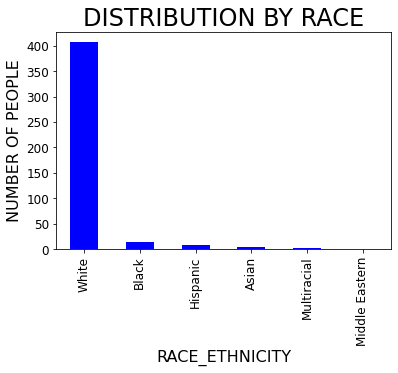

In [22]:
#Most Oscar winners are white. 
def plotdata(data, col, title): 
    #group data 
    grouped_data = data[col].value_counts() 
    #plot graph 
    grouped_data.plot(kind='bar', fontsize=12,color='b') 
    #name the x axis and let the fontsize equals to 16px 
    plt.xlabel( col.upper(), fontsize=16) 
    #name the y axis and let the fontsize equals to 16px 
    plt.ylabel('Number of People'.upper(),fontsize=16) 
    #give the title a name and give it a font-size of 24px 
    plt.title(title.upper(), fontsize=24) 
    plt.show() 
plotdata(dataset,'race_ethnicity', 'distribution by race') 

Text(0.5, 1.0, 'DISTRIBUTION BY COUNTRY')

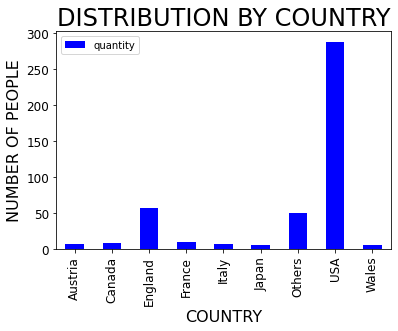

In [23]:
#Most Oscar winners are from USA 
n = 4 
#group country data and rename the columns 
grouped_data = dataset['country'].value_counts().rename_axis('country').reset_index(name='quantity') 
#if country data is less than n, change column name to 'others'  
grouped_data.loc[grouped_data.quantity <= n , 'country'] = 'Others' 
# regroup country data 
new_grouped_data = grouped_data.groupby('country').sum() 
#plot graph of new grouped data and give the bars a color of blue 
new_grouped_data.plot(kind='bar', fontsize=12,color='b') 
#name the x axis and let the fontsize equals to 16px 
plt.xlabel( 'country'.upper(), fontsize=16) 
#name the y axis and let the fontsize equals to 16px 
plt.ylabel('Number of People'.upper(),fontsize=16) 
#give the title a name and give it a font-size of 24px 
plt.title('distribution by country'.upper(), fontsize=24) 

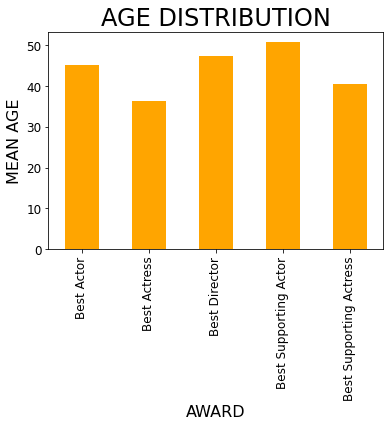

In [24]:
#Calculate the mean of the ages of each of the award
award_data = dataset.groupby('award').award_age.mean()
#plot graph of grouped data and give the bars a color of blue 
award_data.plot(kind="bar", fontsize=12, color='orange') 
#name the x axis and let the fontsize equals to 16px 
plt.xlabel( 'Award'.upper(), fontsize=16) 
#name the y axis and let the fontsize equals to 16px 
plt.ylabel('Mean Age'.upper(),fontsize=16) 
#give the title a name and give it a font-size of 24px 
plt.title('AGE DISTRIBUTION'.upper(), fontsize=24) 
plt.show()

## Discretizing our age

In [25]:
age_buckets = []
age = list(dataset['award_age'])
for i in range(len(age)):
    if age[i] < 35 :#any ages below 35 have been replaced with 1 
        age_buckets.append(1)
    elif age[i] < 45 :#ages between 35 to 44 have been replaced with 2
        age_buckets.append(2)
    elif age[i] < 55 :#ages between 45 to 54 have been replaced with 3
        age_buckets.append(3)
    else:#ages from 55 upwards have been replaced with 4
        age_buckets.append(4)


In [26]:
dataset['age_buckets'] = age_buckets
dataset.head(3)

,birthplace,date_of_birth,race_ethnicity,year_of_award,award,gender,ldob,country,award_age,sexual_orientation,movie,religion,person,age_buckets
0,"Chisinau, Moldova",30-Sep-1895,White,1927,Best Director,Male,11,Moldova,32,Straight,Two Arabian Knights,Na,Lewis Milestone,1
1,"Glasgow, Scotland",02-Feb-1886,White,1930,Best Director,Female,10,Scotland,44,Straight,The Divine Lady,Na,Frank Lloyd,2
2,"Chisinau, Moldova",30-Sep-1895,White,1931,Best Director,Male,11,Moldova,36,Straight,All Quiet on the Western Front,Na,Lewis Milestone,2


## Building our model

In [27]:
# split the data into train and test set
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X=dataset[['race_ethnicity','country','award_age']]
X=pd.get_dummies(X,columns=['race_ethnicity','country'])
y=dataset['award']


# Spliting X and Y in 80 : 20 ratio (train : test)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2,test_size=0.2)

## Training the Logistic Regression model on the Training set

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)

clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

Accuracy score for training data is: 0.447
Accuracy score for test data: 0.352


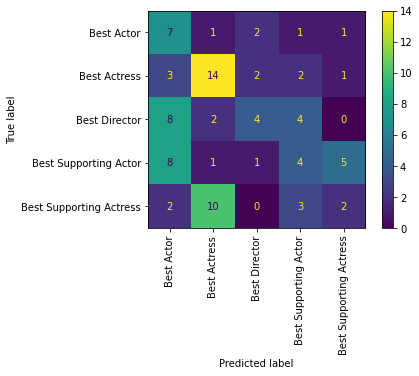

Cross validation mean score: 0.3695824524312896
Cross validation scores [0.27272727 0.38636364 0.40909091 0.36363636 0.43181818 0.3255814
 0.3255814  0.44186047]


In [29]:
#outputing the value of our accuracy
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection

#displaying the value of our cross validation
scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean score: {}".format(scores.mean()))
print("Cross validation scores", scores)

## Training the K-NN model on the Training set

In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
clf.fit(X_train, y_train)

KNeighborsClassifier()

Accuracy score for training data is: 0.510
Accuracy score for test data: 0.307


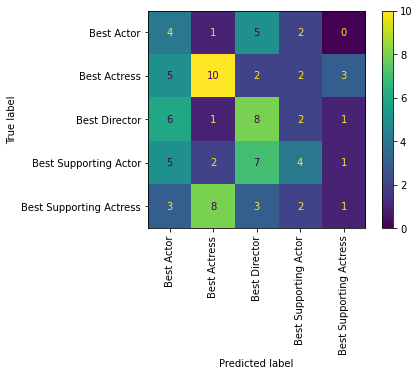

Cross validation mean scores:0.33813424947145876
Cross validation mean scores: [0.27272727 0.36363636 0.36363636 0.31818182 0.36363636 0.27906977
 0.37209302 0.37209302]


In [31]:
#outputing the value of our accuracy
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()
 
#displaying the value of our cross validation

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)

## Training the random forest model on the training set 

Accuracy score for training data is: 0.510
Accuracy score for test data: 0.307


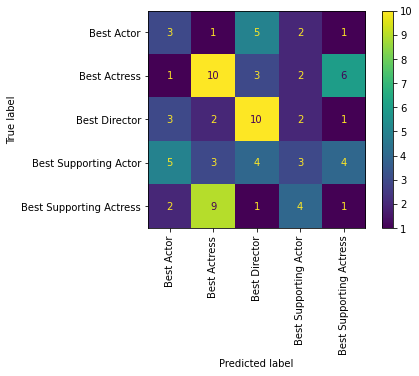

Cross validation mean scores:0.36416490486257924
Cross validation mean scores: [0.22727273 0.34090909 0.43181818 0.31818182 0.40909091 0.41860465
 0.3255814  0.44186047]


In [32]:
#outputing the value of our accuracy 
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()


#displaying the value of our cross validation
scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)
print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)

## IMPROVING OUR MODEL 

## USING FEATURE SELECTION TO DETERMINE THE BEST FEATURES TO USE FROM OUR DATASET

In [33]:

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import OrdinalEncoder



dataset_test= dataset


ord_enc = OrdinalEncoder()
dataset_test["religion"] = ord_enc.fit_transform(dataset_test[["religion"]])
dataset_test["race_ethnicity"] = ord_enc.fit_transform(dataset_test[["race_ethnicity"]])
dataset_test["country"] = ord_enc.fit_transform(dataset_test[["country"]])
dataset_test["sexual_orientation"] = ord_enc.fit_transform(dataset_test[["sexual_orientation"]])
dataset_test["movie"] = ord_enc.fit_transform(dataset_test[["movie"]])
dataset_test["person"] = ord_enc.fit_transform(dataset_test[["person"]])
dataset_test["award_age"] = ord_enc.fit_transform(dataset_test[["award_age"]])
dataset_test["gender"] = ord_enc.fit_transform(dataset_test[["gender"]])



dataset_test.head(11)


X = dataset_test[['race_ethnicity','country','award_age','sexual_orientation','religion', 'movie', 'person','gender']]  #independent columns
y = dataset_test['award']    #target column 
print(X)


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 10 best features 

     race_ethnicity  country  award_age  sexual_orientation  religion  movie  \
0               5.0     18.0       14.0                 5.0      15.0  317.0   
1               5.0     23.0       26.0                 5.0      15.0  242.0   
2               5.0     18.0       18.0                 5.0      15.0   21.0   
3               5.0     30.0       15.0                 5.0      15.0  209.0   
4               5.0     30.0       21.0                 5.0      19.0   34.0   
..              ...      ...        ...                 ...       ...    ...   
436             5.0      7.0       17.0                 5.0      12.0  236.0   
437             5.0      7.0       35.0                 5.0      19.0  210.0   
438             5.0     30.0       37.0                 5.0      15.0   24.0   
439             5.0     30.0       52.0                 5.0      15.0   17.0   
440             5.0     30.0       25.0                 5.0      15.0  299.0   

     person  gender  
0     208.0     1

## Training the Logistic Regression model on the Training set with an added column

In [34]:
# split the data into train and test set
X=dataset[['race_ethnicity','country','award_age','religion','sexual_orientation','gender']]
X=pd.get_dummies(X,columns=['race_ethnicity','country','religion','sexual_orientation','gender'])
y=dataset['award']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)

In [35]:
#importing our logistic regressor 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

Accuracy score for training data is: 0.630
Accuracy score for test data: 0.489
Cross validation mean scores: 0.4820295983086681
Cross validation mean scores: [0.43181818 0.43181818 0.36363636 0.43181818 0.52272727 0.55813953
 0.58139535 0.53488372]


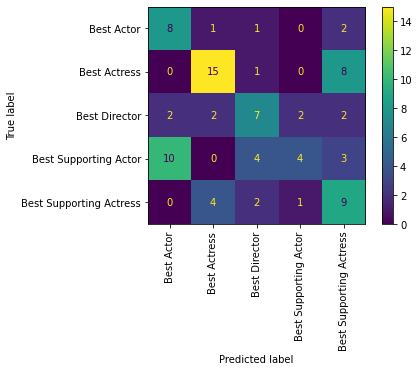

In [36]:
#outputing the value of our accuracy 
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)

#displaying the value of our cross validation
print("Cross validation mean scores: {}".format(scores.mean()))
print("Cross validation mean scores:",scores)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

## Training the K-NN model on the Training set with an added column

In [37]:
from sklearn.neighbors import KNeighborsClassifier

X=dataset[['race_ethnicity','country','award_age','religion','gender']]

X=pd.get_dummies(X,columns=['race_ethnicity','country','religion','gender'])

y=dataset['award']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)

clf = KNeighborsClassifier(n_neighbors=2)

clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

Cross validation mean scores: 0.35835095137420725
Cross validation mean scores: [0.43181818 0.29545455 0.29545455 0.34090909 0.36363636 0.34883721
 0.37209302 0.41860465]


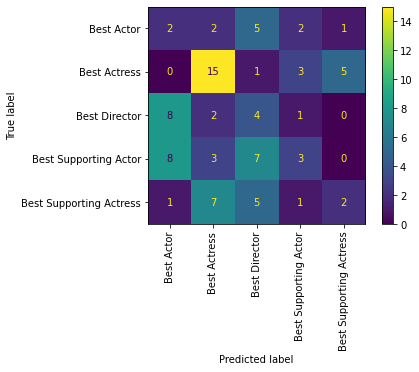

Accuracy score for training data is: 0.648
Accuracy score for test data: 0.295


In [38]:

from sklearn.model_selection import KFold, cross_val_score
from sklearn import feature_selection, linear_model, model_selection

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)

#displaying the value of our cross validation 
print("Cross validation mean scores: {}".format(scores.mean()))
print("Cross validation mean scores:",scores)
plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()



#outputing the value of our accuracy on both the training data and test data
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

## Training the random forest model on the training set with the added column 

In [39]:
# split the data into train and test set

#selecting the columns we would be using for the model 

X=dataset[['race_ethnicity','award_age','religion','country','gender']]
X=pd.get_dummies(X,columns=['race_ethnicity','religion','country','gender'])
y=dataset['award']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,test_size=0.2)


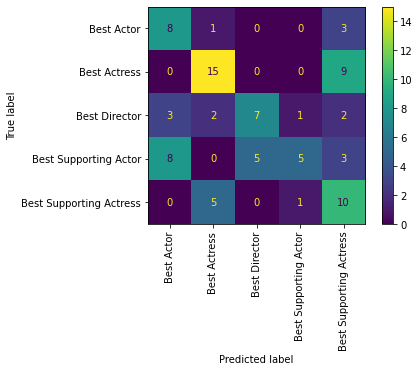

Accuracy score for training data is: 0.748
Accuracy score for test data: 0.511
Cross validation mean scores:0.4876453488372093
Cross validation mean scores: [0.38636364 0.40909091 0.45454545 0.45454545 0.54545455 0.60465116
 0.51162791 0.53488372]


In [40]:

clf = RandomForestClassifier(n_estimators=1000,max_depth=10)

#applying our classifier on the on our training set 
clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test)
plt.xticks(rotation='vertical')
plt.show()

#outputing the value of our accuracy 
print("Accuracy score for training data is: {:4.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score for test data: {:4.3f}".format(clf.score(X_test, y_test)))

scores = model_selection.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=8)

print("Cross validation mean scores:{}".format(scores.mean()))
print("Cross validation mean scores:",scores)


In [41]:
#importing KMeans
from sklearn.cluster import KMeans

In [42]:
cluster = dataset[['race_ethnicity', 'award_age','birthplace','award','sexual_orientation']]
cluster = pd.get_dummies(cluster, columns = ['race_ethnicity','birthplace','award','sexual_orientation'])

## normalisation of the data
cluster = (cluster - cluster.min()) / (cluster.max() - cluster.min())

#print ('raw data', df.head(2))
cluster.head(2)

,award_age,race_ethnicity_0.0,race_ethnicity_1.0,race_ethnicity_2.0,race_ethnicity_3.0,race_ethnicity_4.0,race_ethnicity_5.0,"birthplace_Arlington, USA","birthplace_Astoria, USA","birthplace_Athens, Greece",...,award_Best Actress,award_Best Director,award_Best Supporting Actor,award_Best Supporting Actress,sexual_orientation_0.0,sexual_orientation_1.0,sexual_orientation_2.0,sexual_orientation_3.0,sexual_orientation_4.0,sexual_orientation_5.0
0,0.225806,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.419355,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
#importing train_test_split
from sklearn.model_selection import train_test_split

In [44]:
km = KMeans(random_state=10, max_iter=500)
km.fit(cluster)

KMeans(max_iter=500, random_state=10)

# 3. Clustering

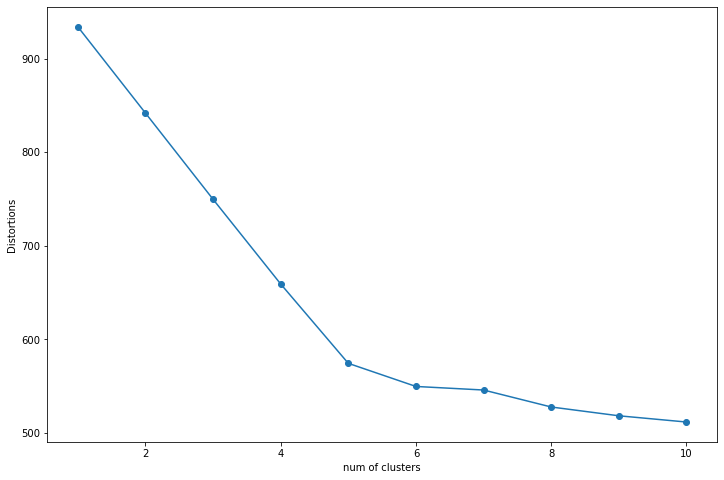

In [45]:
distortions = []
for i in range(1, 11):#iterating through the set range 
    km = KMeans(n_clusters=i, init='random',n_init=10, max_iter=300, random_state=0)
    km.fit(cluster)
    distortions.append(km.inertia_)

#graph
plt.figure(figsize=(12,8))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('Distortions')
plt.show()

## PCA CLUSTERS

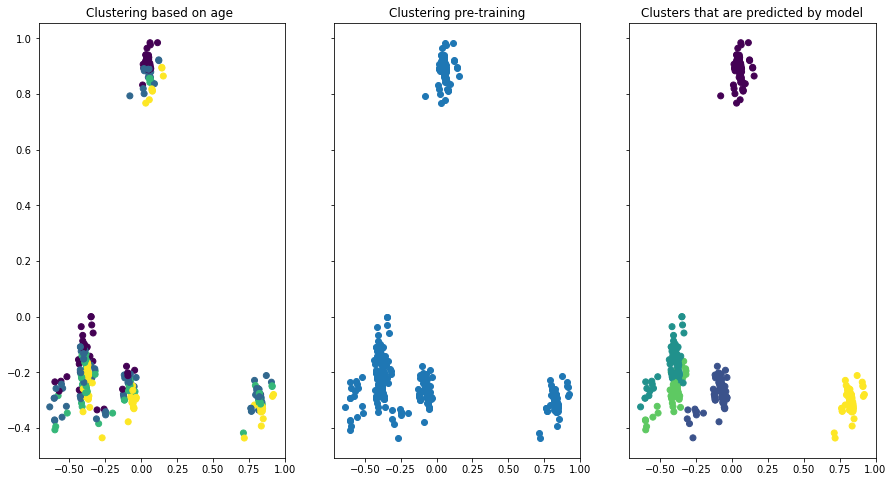

In [53]:
#visualization  of pca clusters

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# From above we apply k-means on 5 clusters
pca = PCA(2)
km = KMeans(n_clusters=5, random_state=10 , max_iter=500)

km.fit(cluster)

predicted = km.predict(cluster)

f,(ax1, ax2,ax3) = plt.subplots(1,3,sharey = True, figsize=(15,8))

plot_columns = pca.fit_transform(cluster)
ax1.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=age_buckets)

ax2.scatter(x=plot_columns[:,1], y=plot_columns[:,0])

ax3.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=predicted)

ax1.title.set_text("Clustering based on age ")

ax2.title.set_text("Clustering pre-training")

ax3.title.set_text("Clusters that are predicted by model")

plt.show()
